In [ ]:
!pip install torch torchvision numpy matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 35.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 31.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 37.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 93.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import os

from torchvision.utils import make_grid
from PIL import Image
from tqdm import tqdm


In [ ]:
# Generator Model
class Generator(nn.Module):
    def __init__(self, z_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.ConvTranspose2d(z_dim, 512, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),

            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),

            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),

            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        return self.model(x)


# Discriminator Model
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x).view(-1, 1)


In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d jessicali9530/celeba-dataset
!unzip celeba-dataset.zip -d dataset


Streaming output truncated to the last 5000 lines.
  inflating: dataset/img_align_celeba/img_align_celeba/197604.jpg  
  inflating: dataset/img_align_celeba/img_align_celeba/197605.jpg  
  inflating: dataset/img_align_celeba/img_align_celeba/197606.jpg  
  inflating: dataset/img_align_celeba/img_align_celeba/197607.jpg  
  inflating: dataset/img_align_celeba/img_align_celeba/197608.jpg  
  inflating: dataset/img_align_celeba/img_align_celeba/197609.jpg  
  inflating: dataset/img_align_celeba/img_align_celeba/197610.jpg  
  inflating: dataset/img_align_celeba/img_align_celeba/197611.jpg  
  inflating: dataset/img_align_celeba/img_align_celeba/197612.jpg  
  inflating: dataset/img_align_celeba/img_align_celeba/197613.jpg  
  inflating: dataset/img_align_celeba/img_align_celeba/197614.jpg  
  inflating: dataset/img_align_celeba/img_align_celeba/197615.jpg  
  inflating: dataset/img_align_celeba/img_align_celeba/197616.jpg  
  inflating: dataset/img_align_celeba/img_align_celeba/197617.jpg

In [ ]:
import os
import shutil
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

# Create necessary directories
os.makedirs("/content/dataset", exist_ok=True)
os.makedirs("/content/generated_samples", exist_ok=True)

# Extract the CelebA dataset
shutil.unpack_archive("/content/celeba-dataset.zip", "/content/dataset")

# Define transformation for images
transform = transforms.Compose([
    transforms.Resize(64),
    transforms.CenterCrop(64),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load the extracted dataset
dataset = torchvision.datasets.ImageFolder(root="/content/dataset/img_align_celeba", transform=transform)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

print("Dataset loaded successfully! Total images:", len(dataset))


Dataset loaded successfully! Total images: 202599


In [ ]:
# Hyperparameters
z_dim = 100
lr = 0.0002
epochs = 7
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize models
G = Generator(z_dim).to(device)
D = Discriminator().to(device)

# Loss and Optimizers
criterion = nn.BCELoss()
optimizer_G = optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D = optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))

# Training Loop
for epoch in range(epochs):
    for i, (real_images, _) in enumerate(tqdm(dataloader)):
        real_images = real_images.to(device)
        batch_size = real_images.size(0)

        # Labels
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        # Train Discriminator
        optimizer_D.zero_grad()
        outputs = D(real_images)
        d_loss_real = criterion(outputs, real_labels)

        z = torch.randn(batch_size, z_dim, 1, 1).to(device)
        fake_images = G(z)
        outputs = D(fake_images.detach())
        d_loss_fake = criterion(outputs, fake_labels)

        d_loss = d_loss_real + d_loss_fake
        d_loss.backward()
        optimizer_D.step()

        # Train Generator
        optimizer_G.zero_grad()
        outputs = D(fake_images)
        g_loss = criterion(outputs, real_labels)

        g_loss.backward()
        optimizer_G.step()

    print(f"Epoch [{epoch+1}/{epochs}] | D Loss: {d_loss.item():.4f} | G Loss: {g_loss.item():.4f}")

    # Save generated images
    torchvision.utils.save_image(fake_images[:25], f"generated_samples/epoch_{epoch+1}.png", normalize=True)

    # Save model checkpoints
    torch.save(G.state_dict(), "generator.pth")
    torch.save(D.state_dict(), "discriminator.pth")


100%|██████████| 1583/1583 [05:19<00:00,  4.95it/s]


Epoch [1/7] | D Loss: 0.5495 | G Loss: 2.6340


100%|██████████| 1583/1583 [05:18<00:00,  4.96it/s]


Epoch [2/7] | D Loss: 0.5105 | G Loss: 4.9496


100%|██████████| 1583/1583 [05:18<00:00,  4.97it/s]


Epoch [3/7] | D Loss: 1.0709 | G Loss: 1.0990


100%|██████████| 1583/1583 [05:17<00:00,  4.99it/s]


Epoch [4/7] | D Loss: 0.1230 | G Loss: 3.8778


100%|██████████| 1583/1583 [05:17<00:00,  4.99it/s]


Epoch [5/7] | D Loss: 0.5760 | G Loss: 3.0574


100%|██████████| 1583/1583 [05:16<00:00,  5.00it/s]


Epoch [6/7] | D Loss: 0.1356 | G Loss: 3.7144


100%|██████████| 1583/1583 [05:17<00:00,  4.99it/s]


Epoch [7/7] | D Loss: 1.4523 | G Loss: 1.0240


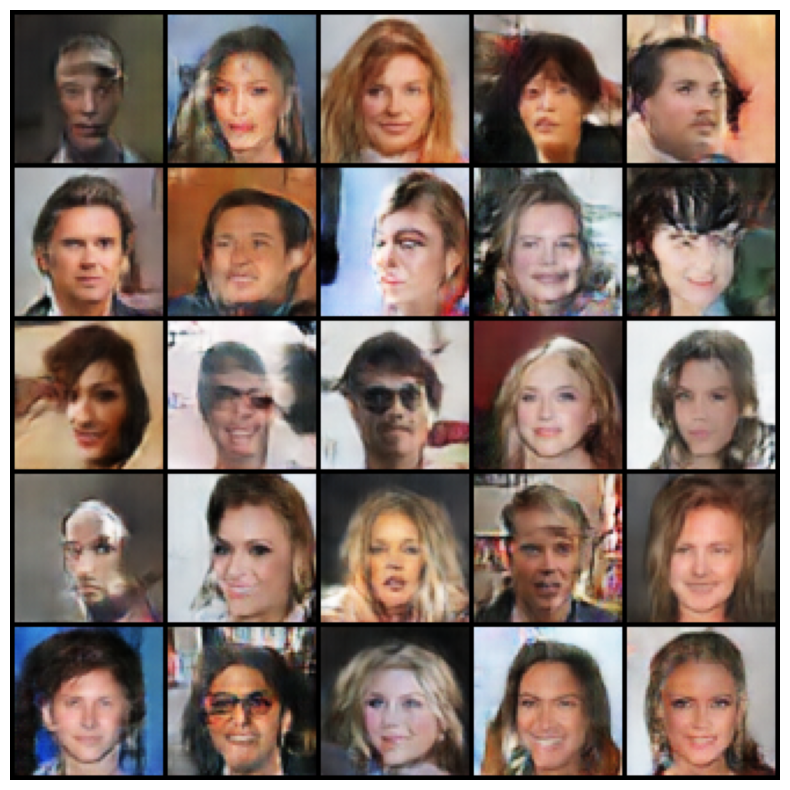

In [ ]:
def generate_images(generator, num_images=25):
    generator.eval()
    z = torch.randn(num_images, z_dim, 1, 1).to(device)
    with torch.no_grad():
        fake_images = generator(z).cpu()
    grid = make_grid(fake_images, nrow=5, normalize=True)
    plt.figure(figsize=(10, 10))
    plt.imshow(np.transpose(grid.numpy(), (1, 2, 0)))
    plt.axis("off")
    plt.show()

# Generate images
generate_images(G)


In [ ]:
from google.colab import files

# Save model checkpoints
torch.save(G.state_dict(), "generator.pth")
torch.save(D.state_dict(), "discriminator.pth")

# Download the models
files.download("generator.pth")
files.download("discriminator.pth")
